In [14]:
import sys,os,math
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt
%matplotlib notebook
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import roc_curve, accuracy_score, auc, make_scorer
from scipy import stats
from numpy import interp
from sklearn.model_selection import GridSearchCV, KFold, StratifiedKFold
from astropy.table import Table
import time

Something strange seems to be happening in the execution of the inner and outer folds of the CV model, here I will investigate if I can understand what the difference is in this case.

In [15]:
feat_df = Table.read('/home/xhall/Documents/PS1CrossMatch/PS1_star_galaxy_0.adamamiller_0.HST_COSMOS_Forcefeatures_xhall_0.fit').to_pandas()
ObjId = range(len(feat_df))
feat_df['ObjId'] = ObjId

In [16]:
in_ts = np.where(feat_df["nDetections"] > 0)
feat_df = feat_df.iloc[in_ts]

In [17]:
len(feat_df)

47825

In [18]:
feat_df.columns

Index(['CLASS_STAR', 'MU_CLASS', 'objid', 'raStack', 'decStack', 'nDetections',
       'qualityFlag', 'iFPSFminusFKron', 'wwFPSFFlux', 'wwFKronFlux',
       'wwFApFlux', 'wwFmeanflxR5', 'wwFmeanflxR6', 'wwFmeanflxR7', 'wwE1',
       'wwE2', 'wwFPSFKronDist', 'wwFPSFApDist', 'wwFPSFApRatio',
       'wwFPSFKronRatio', 'wwFPSFflxR5Ratio', 'wwFPSFflxR6Ratio',
       'wwFPSFflxR7Ratio', 'ObjId'],
      dtype='object')

In [19]:
fnames = ['E1', 'E2', 'FPSFKronDist',
          'FPSFApDist', 'FPSFApRatio',  'FPSFKronRatio',
          'FPSFflxR5Ratio', 'FPSFflxR6Ratio', 'FPSFflxR7Ratio']
fil = 'ww'
features = [fil  + feat for feat in fnames]

In [20]:
feat = feat_df.loc[:,features]

gt = (feat_df.MU_CLASS - 1).astype(int)
whiteKronMag = -2.5*np.log10(feat_df.wwFKronFlux/3631)

X = feat.values
y = np.squeeze(gt.values)

In [33]:

from sklearn.metrics import make_scorer

def fom_score(y_true, y_pred, fpr_fom=0.005):
    """ZTF star-galaxy Figure of Merit (FoM) score.
    
    This metric calculates the true positive rate at a fixed
    false positive rate = 0.005. Assuming that stars are the 
    positive class, the objective is to maximize the FoM.
    
    Parameters
    ----------
    y_true : 1d array-like, or label indicator array / sparse matrix
        Ground truth (correct) labels.
    y_pred : 1d array-like, or label indicator array / sparse matrix
        Predicted labels, as returned by a classifier.
    
    Returns
    -------
    score : float
        The best performance is 1.
    """

    fpr, tpr, threshold = roc_curve(y_true, y_pred)
    fom = interp(fpr_fom, fpr, tpr)
    return fom

fom_scorer = make_scorer(fom_score, needs_threshold=True)

grid = GridSearchCV(RandomForestClassifier(n_jobs=-1),
                    param_grid={'n_estimators': [500, 600, 700, 800, 900, 1000, 1100, 1200, 1300, 1400, 1500],
                                'min_samples_leaf': [2],
                                'max_features': [3]},
                    scoring=fom_scorer,
                    cv=10)

In [34]:
rs = 23
N_outter_splits = 10
kf_cv = KFold(n_splits=N_outter_splits, shuffle=True, random_state=rs)

tuned_n_estimators = np.empty(N_outter_splits)
tuned_max_features = np.empty(N_outter_splits)
tuned_min_samples_leaf = np.empty(N_outter_splits)
fold_fom = np.empty(N_outter_splits)
fold_auc = np.empty(N_outter_splits)
fold_acu = np.empty(N_outter_splits)
interp_fpr = 10**(np.arange(-4, 0, 0.01))
interp_fpr = np.append(interp_fpr, 0.005)
interp_fpr = np.sort(interp_fpr)
interp_tpr = pd.DataFrame(index=range(len(interp_fpr)), columns=range(N_outter_splits))
CV_test_list = []
CV_proba_list = []

start = time.time()
print('Fold num: ')
for fold, (train, test) in zip(range(N_outter_splits), kf_cv.split(y)):
    print('{:d}/{:d}'.format(fold, N_outter_splits))
    grid.fit(X[train], y[train])
    if fold == 0:
        params_grid = grid.cv_results_['params']
        mean_test_score =  grid.cv_results_['mean_test_score']
    else: 
        mean_test_score = np.c_[mean_test_score, grid.cv_results_['mean_test_score']]
    tuned_param = grid.cv_results_['params'][np.argmin(grid.cv_results_['rank_test_score'])]
    tuned_n_estimators[fold] = tuned_param['n_estimators']
    tuned_max_features[fold] = tuned_param['max_features'] 
    tuned_min_samples_leaf[fold] = tuned_param['min_samples_leaf']
    
    best_model = RandomForestClassifier(n_estimators = tuned_param['n_estimators'], 
                                        min_samples_leaf = tuned_param['min_samples_leaf'], 
                                        max_features = tuned_param['max_features'], 
                                        n_jobs=-1)

    best_model.fit(X[train], y[train])
    predict = best_model.predict(X[test])
    proba = best_model.predict_proba(X[test])[:,1]
    CV_test_list.append(test)
    CV_proba_list.append( proba)
    fold_acu[fold] = accuracy_score(y[test], predict)
    fpr, tpr, _ = roc_curve(y[test], proba)
    fold_auc[fold] = auc(fpr, tpr)
    interp_tpr[fold] = interp(interp_fpr, fpr, tpr)
    fold_fom[fold] =  interp_tpr[interp_fpr==0.005][fold].values[0]
    elapsed_time = time.time() - start
    print('elapsed_time:{:.2f} [min]'.format(elapsed_time/60))

Fold num: 
0/10
elapsed_time:13.88 [min]
1/10
elapsed_time:27.73 [min]
2/10
elapsed_time:41.77 [min]
3/10
elapsed_time:55.90 [min]
4/10
elapsed_time:69.97 [min]
5/10
elapsed_time:83.98 [min]
6/10
elapsed_time:97.91 [min]
7/10
elapsed_time:111.85 [min]
8/10
elapsed_time:125.87 [min]
9/10
elapsed_time:139.83 [min]


In [35]:
mean_test_score_tab = pd.DataFrame(mean_test_score)
mean_test_score_tab

,0,1,2,3,4,5,6,7,8,9
0,0.652878,0.652648,0.652096,0.654159,0.652086,0.655206,0.647949,0.655122,0.654075,0.654251
1,0.654348,0.653752,0.653571,0.655081,0.652548,0.657412,0.647856,0.655859,0.652418,0.654621
2,0.651039,0.653018,0.652834,0.653698,0.651902,0.653919,0.646286,0.654293,0.652972,0.654529
3,0.650763,0.653109,0.655046,0.654435,0.649595,0.653643,0.648317,0.652267,0.650303,0.655453
4,0.651590,0.653479,0.652371,0.655634,0.651625,0.655574,0.647394,0.653095,0.653247,0.654621
5,0.652970,0.653109,0.654124,0.655266,0.652363,0.655023,0.648409,0.654017,0.654351,0.655360
6,0.651866,0.653385,0.651449,0.655634,0.653470,0.657871,0.649241,0.653372,0.652603,0.653789
7,0.651775,0.650901,0.654677,0.656556,0.651533,0.654746,0.649702,0.653925,0.651776,0.653327
8,0.652877,0.652005,0.653386,0.655634,0.651532,0.656494,0.649056,0.654386,0.653339,0.654991
9,0.652786,0.651820,0.654401,0.655912,0.650979,0.657505,0.647856,0.655216,0.652143,0.654159


In [36]:
mean_FoM = np.mean(mean_test_score_tab, axis=1)
std_FoM = np.std(mean_test_score_tab, axis=1)

In [37]:
print('Mean FoM = {:.4f} +/- {:.4f}'.format(np.mean(fold_fom), np.std(fold_fom)))

Mean FoM = 0.6532 +/- 0.0143


In [38]:
print('Optimal model params:')
print('\tN_tree = {:.1f}'.format(np.mean(tuned_n_estimators)))
print('\tm_try = {:.1f}'.format(np.mean(tuned_max_features)))
print('\tnodesize = {:.1f}'.format(np.mean(tuned_min_samples_leaf)))

Optimal model params:
	N_tree = 900.0
	m_try = 3.0
	nodesize = 2.0


In [39]:
print(tuned_n_estimators)
print(tuned_max_features)
print(tuned_min_samples_leaf)
print(fold_fom)

[ 600.  600.  800. 1200. 1100. 1100. 1200.  600. 1000.  800.]
[3. 3. 3. 3. 3. 3. 3. 3. 3. 3.]
[2. 2. 2. 2. 2. 2. 2. 2. 2. 2.]
[0.65762712 0.66135792 0.64309211 0.63786008 0.66448445 0.63613232
 0.67886179 0.63560732 0.66779374 0.64943457]


In [40]:
mean_test_score_tab = pd.DataFrame(mean_test_score)
mean_test_score_tab

,0,1,2,3,4,5,6,7,8,9
0,0.652878,0.652648,0.652096,0.654159,0.652086,0.655206,0.647949,0.655122,0.654075,0.654251
1,0.654348,0.653752,0.653571,0.655081,0.652548,0.657412,0.647856,0.655859,0.652418,0.654621
2,0.651039,0.653018,0.652834,0.653698,0.651902,0.653919,0.646286,0.654293,0.652972,0.654529
3,0.650763,0.653109,0.655046,0.654435,0.649595,0.653643,0.648317,0.652267,0.650303,0.655453
4,0.651590,0.653479,0.652371,0.655634,0.651625,0.655574,0.647394,0.653095,0.653247,0.654621
5,0.652970,0.653109,0.654124,0.655266,0.652363,0.655023,0.648409,0.654017,0.654351,0.655360
6,0.651866,0.653385,0.651449,0.655634,0.653470,0.657871,0.649241,0.653372,0.652603,0.653789
7,0.651775,0.650901,0.654677,0.656556,0.651533,0.654746,0.649702,0.653925,0.651776,0.653327
8,0.652877,0.652005,0.653386,0.655634,0.651532,0.656494,0.649056,0.654386,0.653339,0.654991
9,0.652786,0.651820,0.654401,0.655912,0.650979,0.657505,0.647856,0.655216,0.652143,0.654159


In [68]:
rs = 23
N_outter_splits = 10
kf_cv = KFold(n_splits=N_outter_splits, shuffle=True, random_state=rs)
strat_cv = StratifiedKFold(10, shuffle=True, random_state=rs)


fold_fom = np.empty(N_outter_splits)
fold_auc = np.empty(N_outter_splits)
fold_acu = np.empty(N_outter_splits)
interp_fpr = 10**(np.arange(-4, 0, 0.01))
interp_fpr = np.append(interp_fpr, 0.005)
interp_fpr = np.sort(interp_fpr)
interp_tpr = pd.DataFrame(index=range(len(interp_fpr)), columns=range(N_outter_splits))
CV_test_list = []
CV_proba_list = []
outer_CV_proba = np.empty_like(y)

start = time.time()
print('Fold num: ')
for fold, (train, test) in zip(range(N_outter_splits), kf_cv.split(y)):
    
    best_model = RandomForestClassifier(n_estimators = #, 
                                        min_samples_leaf = #, 
                                        max_features = #, 
                                        n_jobs=-1)

    best_model.fit(X[train], y[train])
    predict = best_model.predict(X[test])
    proba = best_model.predict_proba(X[test])[:,1]
    CV_test_list.append(test)
    CV_proba_list.append( proba)
    outer_CV_proba[test] = proba


    fold_acu[fold] = accuracy_score(y[test], predict)
    fpr, tpr, _ = roc_curve(y[test], proba)
    fold_auc[fold] = auc(fpr, tpr)
    interp_tpr[fold] = interp(interp_fpr, fpr, tpr)
    fold_fom[fold] =  interp_tpr[interp_fpr==0.005][fold].values[0]
    elapsed_time = time.time() - start
    print('elapsed_time:{:.2f} [min]'.format(elapsed_time/60))

Fold num: 
elapsed_time:0.71 [min]
elapsed_time:1.41 [min]
elapsed_time:2.04 [min]
elapsed_time:2.64 [min]
elapsed_time:3.27 [min]
elapsed_time:3.96 [min]
elapsed_time:4.57 [min]
elapsed_time:5.19 [min]
elapsed_time:5.86 [min]
elapsed_time:6.52 [min]


In [69]:
mean_FoM = np.mean(mean_test_score_tab, axis=1)
std_FoM = np.std(mean_test_score_tab, axis=1)

array([ 0.702969  ,  0.65285863,  0.71621622,  0.68360791,  0.71393035,
        0.74066611,  0.72790256,  0.68628525,  0.69738932,  0.68338836])

In [31]:
print('Mean FoM = {:.4f} +/- {:.4f}'.format(np.mean(fold_fom), np.std(fold_fom)))

Mean FoM = 0.6230 +/- 0.0170


In [73]:
rs = 23
N_outter_splits = 10
kf_cv = KFold(n_splits=N_outter_splits, shuffle=True, random_state=rs)
strat_cv = StratifiedKFold(10, shuffle=True, random_state=rs)


fold_fom = np.empty(N_outter_splits)
fold_auc = np.empty(N_outter_splits)
fold_acu = np.empty(N_outter_splits)
interp_fpr = 10**(np.arange(-4, 0, 0.01))
interp_fpr = np.append(interp_fpr, 0.005)
interp_fpr = np.sort(interp_fpr)
interp_tpr = pd.DataFrame(index=range(len(interp_fpr)), columns=range(N_outter_splits))
CV_test_list = []
CV_proba_list = []
outer_CV_proba = np.empty_like(y, dtype=float)

start = time.time()
print('Fold num: ')
for fold, (train, test) in zip(range(N_outter_splits), strat_cv.split(X, y)):
    
    best_model = RandomForestClassifier(n_estimators = #, 
                                        min_samples_leaf = #, 
                                        max_features = #, 
                                        n_jobs=-1)

    best_model.fit(X[train], y[train])
    predict = best_model.predict(X[test])
    proba = best_model.predict_proba(X[test])[:,1]
    CV_test_list.append(test)
    CV_proba_list.append( proba)
    outer_CV_proba[test] = proba


    fold_acu[fold] = accuracy_score(y[test], predict)
    fpr, tpr, _ = roc_curve(y[test], proba)
    fold_auc[fold] = auc(fpr, tpr)
    interp_tpr[fold] = interp(interp_fpr, fpr, tpr)
    fold_fom[fold] =  interp_tpr[interp_fpr==0.005][fold].values[0]
    elapsed_time = time.time() - start
    print('elapsed_time:{:.2f} [min]'.format(elapsed_time/60))

Fold num: 
elapsed_time:0.69 [min]
elapsed_time:1.37 [min]
elapsed_time:2.03 [min]
elapsed_time:2.64 [min]
elapsed_time:3.25 [min]
elapsed_time:3.90 [min]
elapsed_time:4.50 [min]
elapsed_time:5.08 [min]
elapsed_time:5.67 [min]
elapsed_time:6.27 [min]


<IPython.core.display.Javascript object>


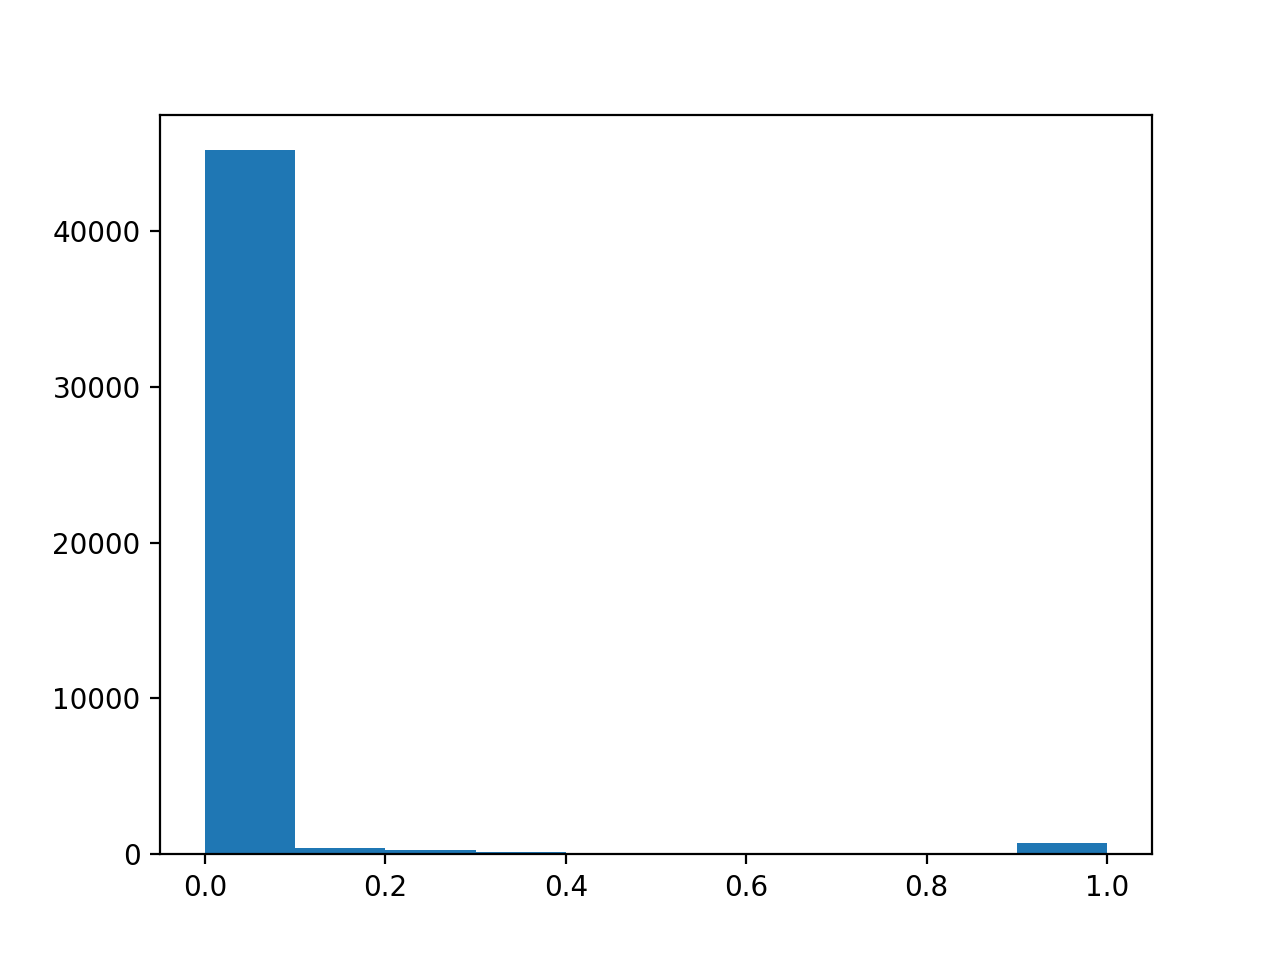

(array([ 45148.,    423.,    273.,    134.,     98.,     83.,     61.,
            61.,     79.,    733.]),
 array([ 0. ,  0.1,  0.2,  0.3,  0.4,  0.5,  0.6,  0.7,  0.8,  0.9,  1. ]),
 <a list of 10 Patch objects>)

In [86]:
plt.hist(outer_CV_proba)

<IPython.core.display.Javascript object>


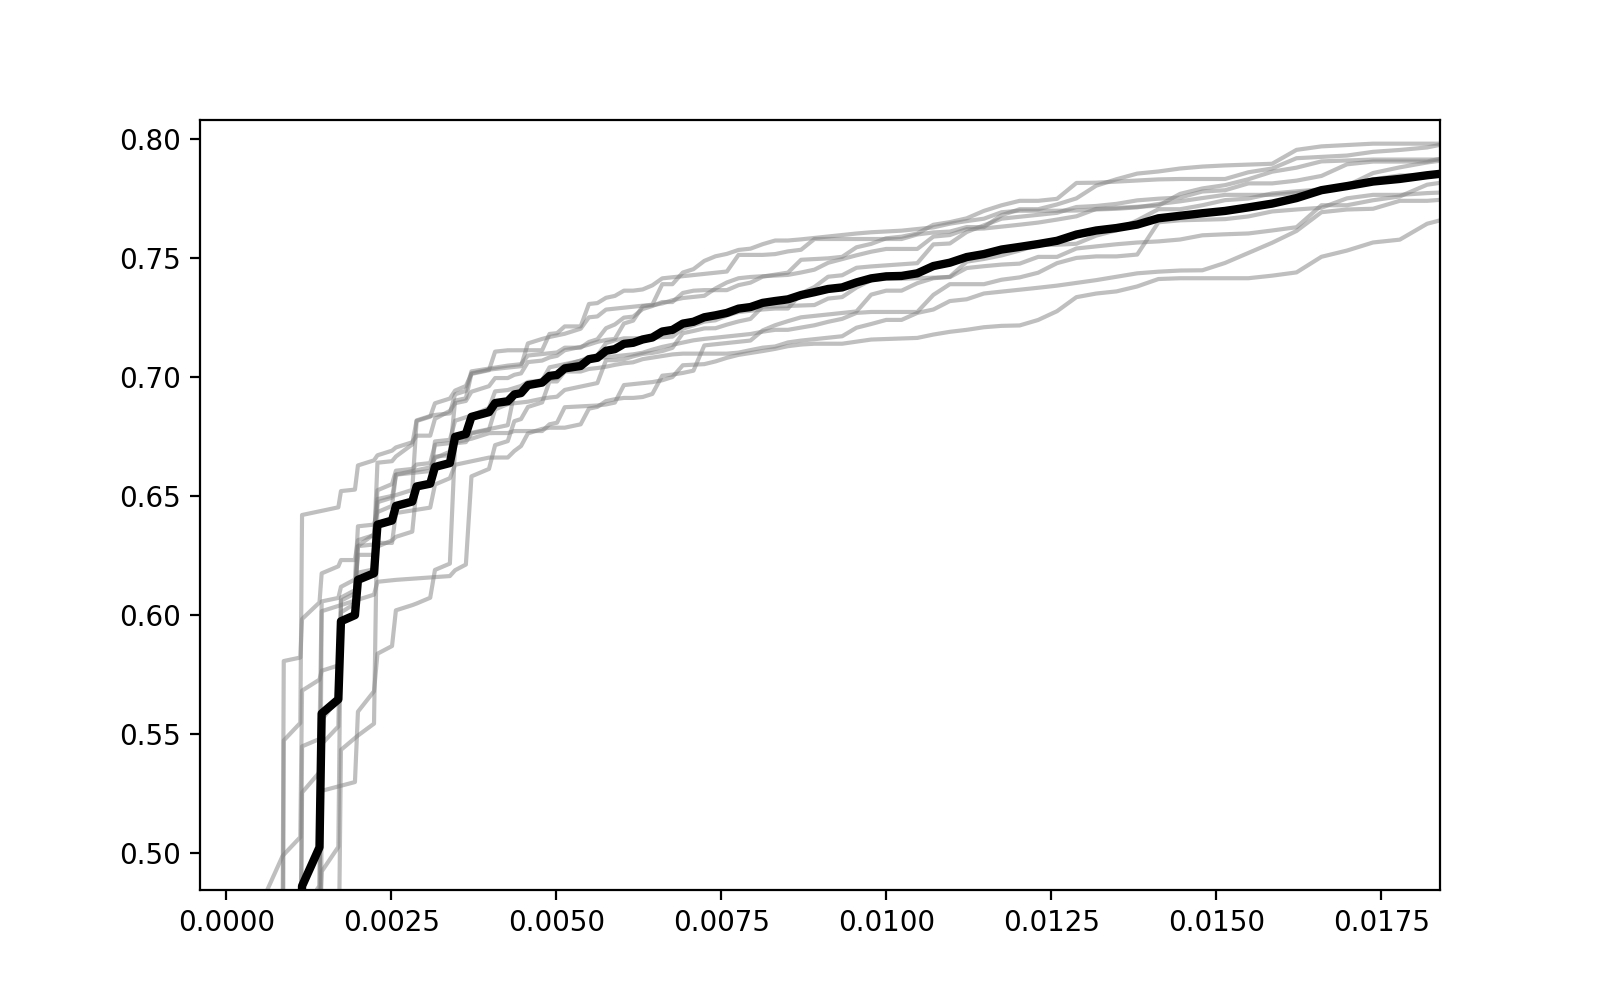

In [88]:
plt.figure(figsize=(8, 5))
plt.plot(interp_fpr, interp_tpr, alpha=0.5, color='grey')
plt.plot(interp_fpr, np.average(interp_tpr, axis=1), color='k', linewidth=3)
